# Exercise 9: Canny Edge Detection

https://docs.opencv.org/4.6.0/da/d22/tutorial_py_canny.html

In this exercise you will learn about:
- The concept of Canny Edge Detection.
- The OpenCV function [cv.Canny()](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de).

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Theory

[Canny Edge Detection](https://en.wikipedia.org/wiki/Canny_edge_detector) is a popular edge detection algorithm, developed by John F. Canny in 1986.

It is a multi-stage algorithm, operating on grayscale images, divided into four steps.

### 1. Noise Reduction

<p>

<img width="250" height="250" src="../notebook_images/gaussian_kernel.png" style="padding: 10px; float: right;">

Since edge (gradient) detection is susceptible to noise in the image, the first step is to remove the noise in the image (i.e. smooth/blur the image) with a 5x5 Gaussian kernel (filter), e.g.:

$$
K = \frac{1}{273}

\begin{bmatrix}
1 & 4 & 7 & 4 & 1\\
4 & 16 & 26 & 16 & 4\\
7 & 26 & 41 & 26 & 7\\
4 & 16 & 26 & 16 & 4\\
1 & 4 & 7 & 4 & 1
\end{bmatrix}
$$

The size of the kernel determines the degree of smoothing (blurring) in the image:
- larger kernel => more smoothing
- smaller kernel => less smoothing.
</p>

### 2. Finding Intensity Gradients in the Image

<p>

<img width="400" height="200" src="../notebook_images/gradient_x.png" style="padding: 10px; float: right;">

The smoothed image $f$ is then filtered with a Sobel kernel in both the horizontal ($x$) and vertical ($y$) directions to get the first derivative in the horizontal direction ($\frac{\partial f}{\partial x}$) and the vertical direction ($\frac{\partial f}{\partial y}$), e.g.:

$$
K_x =

\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}

\quad \& \quad

K_y =

\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

Imagine sliding the $K_x$ kernel, from left to right, over a vertical black edge as in the figure to the right. The Sobel kernel carries out a first order discrete differentiation, but actually does a little smoothing too, so let's just consider the bottom row in the $K_x$ kernel to make the example easier, i.e. we are sliding $ \begin{bmatrix} -1 & 0 & 1 \end{bmatrix} $ from left to right over the vertical black edge. The kernel will move from white-to-black-to-white (255-to-0-to-255), as shown in the middle picture.

If you compute the weighted sum of the kernel with the image's pixels, you can convince yourself that the first order derivative will look something like the rightmost picture (but will of course be discrete, not continuous). The same reasoning can be applied when sliding the $K_y$ kernel from top to bottom over a horizontal black line (which computes the partial derivative of the image with respect to the y direction).

<img width="400" height="100" src="../notebook_images/gradient_x_y.png" style="padding: 10,10,10,5px; float: right;">

From these two filtered images, we can find the edge gradient, magnitude and direction (angle) for each pixel as follows:

$$
\nabla f = \left[ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right],

\quad

||\nabla f|| = \sqrt{ \left( \frac{\partial f}{\partial x} \right) ^2 + \left( \frac{\partial f}{\partial y} \right) ^2 },

\quad

\angle \nabla f = \theta = tan^{−1} \left( \frac{ \frac{\partial f}{\partial y} }{ \frac{\partial f}{\partial x} } \right)
$$

The gradient direction is always perpendicular to the edges, and is rounded to one of four angles representing the vertical, horizontal and two diagonal directions.

</p>

### 3. Non-maximum Suppression

<p>

<img width="250" height="250" src="../notebook_images/non_maximum_suppression2.png" style="padding: 10px; float: right;">

After getting the gradient magnitude and direction, a full scan of the image is done to remove any pixels that may not constitute an edge. This is done by looping through every pixel, checking if it's a local maximum in its neighborhood in the direction of the gradient, and if not, setting the pixel's value to zero.

This is illustrated in the figure to the right, where the left orange arrow represents the gradient (with an angle of $\pi$ radians or 180 degrees) for the center pixel (highlighted in red), why the center pixel is compared to the white and black pixels to the left and right respectively, and since the left pixel has a higher intensity (white) than the center pixel (gray), the center pixel's intensity will be set to zero.

This is also shown in the left figure below, where point A is on a vertical edge. The gradient direction is normal (90 degrees perpendicular) to the edge. Point B and C are in the gradient direction (i.e. lie on the gradient arrow), and within the neighbourhood (1 pixel in any direction) of A. Therefore, the intensity of point A is compared with the intensities of point B and C, to see if point A is a local maximum (i.e. if A has higher intensity that B and C). If so, point A is considered for next step below, otherwise, it is suppressed (i.e. its intensity value is set to 0).

In other words, this supresses non-maximum pixels along an edge, hence the name "non-maximum supression". The result you get is a binary image with "thin edges". The right figure below illustrates this, where non-maximum supression eliminates the three rightmost candidate edges, and keeps the leftmost edge (as the "true edge").

<img width="400" height="200" src="../notebook_images/non_maximum_suppression.jpg">
<img width="400" height="150" src="../notebook_images/true_edge.png" style="padding-left: 80px;">
</p>

### 4. Hysteresis Thresholding

<p>

<img width="300" height="300" src="../notebook_images/hysteresis.png" style="padding: 10px; float: right;">

This step determines which candidate edges are really edges and which are not. In order to do this, we need two threshold values, $low$ and $high$. Any edge with an intensity above or equal to the $high$ threshold, is a "sure-edge", and any edge below the $low$ threshold is a "non-edge", and therefore discarded. Any edge that lies between the $low$ and $high$ thresholds, is classified as an "edge" or "non-edge" based on its connectivity with other edges, i.e. if it is connected to a "sure-edge" pixel, it is considered to be part of an edge, otherwise, it is discarded.

In the figure to the right, edges A and B are above the $high$ threshold, and are therefore considered "sure-edges". Edge D is below the $low$ threshold, why it is considered a "non-edge", and is discarded. Edge E is between the $low$ and $high$ thresholds, but not connected to any "sure-edge", so it is discarded. Edge C is also between the $low$ and $high$ thresholds, but is connected to a "sure-edge" (edge B), so it is considered a valid edge.

From the example, it is obvious that we need to select good values for the $low$ and $high$ thresholds to get the correct result. This step will also remove noise pixels on the assumption that edges are long lines.

By applying the the Canny edge detection algorithm to an image, we end up with the strong edges in the image.
</p>

## Canny Edge Detection in OpenCV

OpenCV puts all the above in single function [cv.Canny()](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de).

`cv.Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) -> edges`
- `image` is the 8-bit input image.
- `threshold1` is the $low$ threshold value for the hysteresis procedure.
- `threshold2` is the $high$ threshold value for the hysteresis procedure.
- `apertureSize` is the size of Sobel kernel used to find image gradients (default=3). 
- `L2gradient` is a boolean that determines the equation used for finding the gradient magnitude:
  - `False`: (default) uses the less accurate L1 norm: $|\frac{ \partial f}{ \partial x}| + |\frac{ \partial f}{ \partial y}|$.
  - `True`: uses the more accurate L2 norm: $\sqrt{ \left( \frac{ \partial f}{ \partial x} \right) ^2 + \left( \frac{ \partial f}{ \partial y} \right) ^2 }$.

The function returns the detected `edges`.

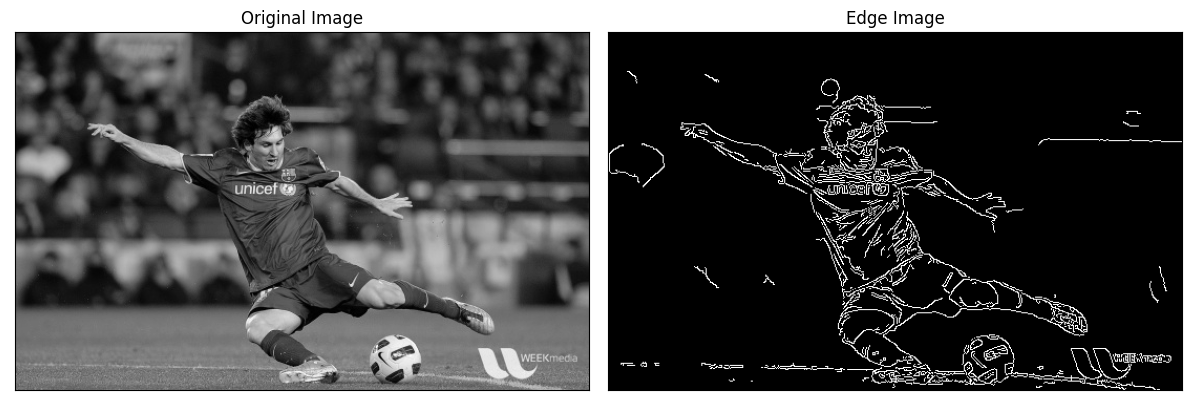

In [2]:
# Read in an image as grayscale
img = cv.imread('../data/messi5.jpg', 0)

# Apply Canny edge detection
# with thresholds low=100, high=200
edges = cv.Canny(img, 100, 200)

# Plot the original image and the image with detected edges
plt.figure(figsize=(12,4))
plt.subplot(121), plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

## Canny Edge Detection from Scratch

If you want a better understanding of how the Canny Edge Detection algorithm works, and how to implement it in python from scratch, visit [this link](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123) with its associated 
[Github repository](https://github.com/FienSoP/canny_edge_detector/blob/master/canny_edge_detector.py), but also make sure you understand the error in the hysteresis calculation of connected components (i.e. "weak edges" connected to "strong", "sure-edges") in that article, by visiting
[this link](http://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch), which describes why the image needs to be scanned four times, i.e.:
- top-to-bottom, left-to-right.
- top-to-bottom, right-to-left.
- bottom-to-top, left-to-right.
- bottom-to-top, right-to-left.